In [ ]:
import sys
sys.path.append('..')

import torch
import os
import torch.nn as nn
import pandas as pd 
import numpy as np
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from LOBnet.Orderbooks import FI2010_Orderbook_Optimized

In [ ]:
datapath = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "data", "BenchmarkDatasets_csv", "Auction", "1.Auction_Zscore", "Auction_Zscore_Testing"))
window_size = 100
overlap_percent = 25  # 25% overlap between windows
num_workers = 5

In [ ]:
# initialize dataset
dataset = FI2010_Orderbook_Optimized(
    root_path=datapath,
    window_size=window_size,
    overlap_percent=overlap_percent,
    num_workers=num_workers,
    verbose=True
)

Processing CSV Files:   0%|          | 0/9 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause cr


Raw price movement statistics:
Mean: 1.9958
Std: 0.8641
Min: 1.0000
Max: 3.0000

Label distribution:
0    2057
1    1388
2    2034
Name: count, dtype: int64


In [ ]:
# Load dataset

batch_size = 32
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False,
    collate_fn=lambda batch: (
        torch.stack([x[0] for x in batch]).transpose(1, 2).unsqueeze(1),
        torch.stack([x[1] for x in batch])
    )   
)

print(f"Test set size: {len(dataset)}")

Test set size: 5479


In [ ]:
# Model Imports

from LOBnet.Models import BaselineDeepLOB
# from LOBnet.Models import DeepLOB_Network_v1
from LOBnet.Models import DeepLOB_Network_v2
# from LOBnet.Models import DeepLOB_Network_v3
from LOBnet.Models import TransformerLOB

In [ ]:
# Model List

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

models = {
    "baseline_model" : BaselineDeepLOB(y_len=3,device=device).to(device),
    "transformer_model" : TransformerLOB(y_len=3, device=device).to(device),
    # "deepLOB_v1" : DeepLOB_Network_v1(y_len=3, device=device).to(device),
    # "deepLOB_v2" : DeepLOB_Network_v2(y_len=3, device=device).to(device),
    "deepLOB_v2" : DeepLOB_Network_v2().to(device),
}

In [ ]:
# Ripped from updated_models

def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # convert one-hot encoded outputs to class predictions
            predictions = outputs.argmax(dim=1)
            true_labels = batch_y.argmax(dim=1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())
    
    return all_predictions, all_labels

Loading saved model from /Users/tommydenezza/Desktop/DeepLearning/LOBnet/bestModels/baseline_model.pth

baseline_model:
Classification Report:
              precision    recall  f1-score   support

 No Movement       0.52      0.51      0.51      2057
          Up       0.57      0.59      0.58      1388
        Down       0.50      0.49      0.50      2034

    accuracy                           0.52      5479
   macro avg       0.53      0.53      0.53      5479
weighted avg       0.52      0.52      0.52      5479



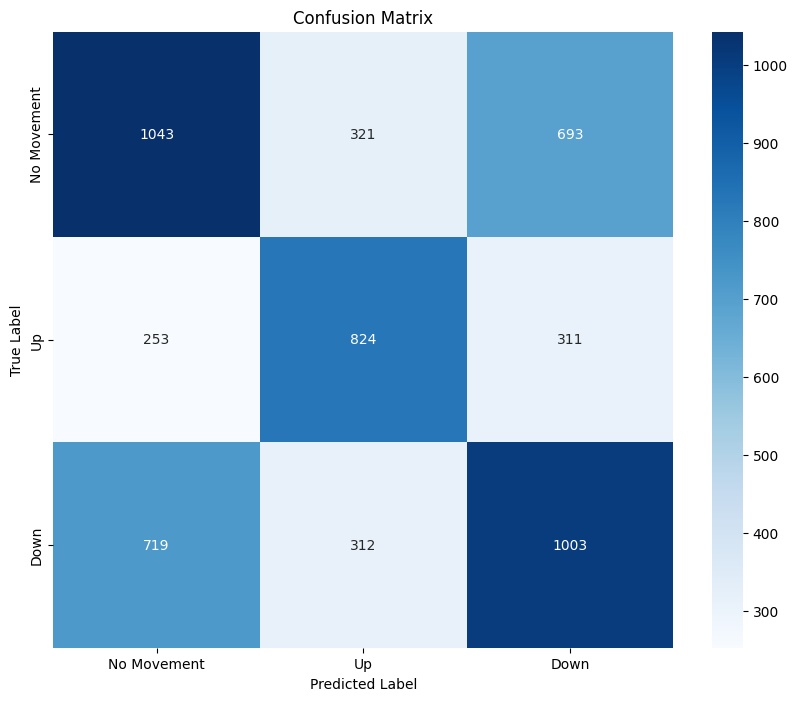

Loading saved model from /Users/tommydenezza/Desktop/DeepLearning/LOBnet/bestModels/transformer_model.pth


RuntimeError: Error(s) in loading state_dict for TransformerLOB:
	Missing key(s) in state_dict: "conv_reduction.1.weight", "conv_reduction.1.bias", "conv_reduction.1.running_mean", "conv_reduction.1.running_var". 
	Unexpected key(s) in state_dict: "conv_reduction.4.weight", "conv_reduction.4.bias", "transformer_encoder.layers.1.self_attn.in_proj_weight", "transformer_encoder.layers.1.self_attn.in_proj_bias", "transformer_encoder.layers.1.self_attn.out_proj.weight", "transformer_encoder.layers.1.self_attn.out_proj.bias", "transformer_encoder.layers.1.linear1.weight", "transformer_encoder.layers.1.linear1.bias", "transformer_encoder.layers.1.linear2.weight", "transformer_encoder.layers.1.linear2.bias", "transformer_encoder.layers.1.norm1.weight", "transformer_encoder.layers.1.norm1.bias", "transformer_encoder.layers.1.norm2.weight", "transformer_encoder.layers.1.norm2.bias", "transformer_encoder.layers.2.self_attn.in_proj_weight", "transformer_encoder.layers.2.self_attn.in_proj_bias", "transformer_encoder.layers.2.self_attn.out_proj.weight", "transformer_encoder.layers.2.self_attn.out_proj.bias", "transformer_encoder.layers.2.linear1.weight", "transformer_encoder.layers.2.linear1.bias", "transformer_encoder.layers.2.linear2.weight", "transformer_encoder.layers.2.linear2.bias", "transformer_encoder.layers.2.norm1.weight", "transformer_encoder.layers.2.norm1.bias", "transformer_encoder.layers.2.norm2.weight", "transformer_encoder.layers.2.norm2.bias". 
	size mismatch for transformer_encoder.layers.0.linear1.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([128, 32]).
	size mismatch for transformer_encoder.layers.0.linear1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for transformer_encoder.layers.0.linear2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([32, 128]).

In [ ]:
for model_name, model in models.items():
    model_path = os.path.abspath(os.path.join("..", "bestModels", model_name + ".pth"))
    if os.path.exists(model_path):
        print(f"Loading saved model from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()  # set to evaluation mode
        predictions, true_labels = evaluate_model(model, test_loader, device)

        print(f"\n{model_name}:\nClassification Report:")
        print(classification_report(true_labels, predictions, 
                                target_names=['No Movement', 'Up', 'Down']))

        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(true_labels, predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Movement', 'Up', 'Down'],
                    yticklabels=['No Movement', 'Up', 'Down'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
    else:
        print(f"No saved model found at {model_path}. Please train the model first.")

    